In [ ]:

import tensorflow as tf
tf.config.list_physical_devices('GPU')
!nvidia-smi


Tue Apr 15 16:19:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io
import statistics
from sklearn.metrics import roc_curve, auc # type: ignore
from sklearn.metrics import roc_auc_score # type: ignore

n_u = 60                      
n_l = 20                       
n_h = n_u + n_l               
hidden_unit = int(np.ceil(np.sqrt((n_u+1)*n_l+1) + 10)) 
test_size = 220              
batch_size = 64
OUT_STEPS = 20                
tail = n_h + OUT_STEPS        
initial_learning_rate = 1e-3  
decay_rate = 0.99             
max_epochs = 50        
detect_test_every = 10      


In [ ]:
# Constructing LSTM training data using a sliding window approach
def generate_lstm_training_data(signals, window_size, out_steps):
    samples = []
    targets = []
    for signal in signals:
        for i in range(len(signal) - window_size - out_steps + 1):
            window = signal[i : i + window_size]
            target = signal[i + window_size + out_steps - 1]
            samples.append(window)
            targets.append(target)
    x = np.array(samples).reshape(-1, window_size, 1)
    y = np.array(targets).reshape(-1, 1)
    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)
def generate_lstm_test_data_with_y(signal, window_size, out_steps):
    samples = []
    targets = []
    for i in range(len(signal) - window_size - out_steps + 1):
        window = signal[i : i + window_size]
        target = signal[i + window_size + out_steps - 1]
        samples.append(window)
        targets.append(target)
    x = np.array(samples).reshape(-1, window_size, 1)
    y = np.array(targets).reshape(-1, 1)
    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)


In [ ]:

def TestDetection(model):
    error_absolute_5db = np.zeros ((test_defect_5db.shape[1], test_size))
    error_absolute_10db = np.zeros ((test_defect_5db.shape[1], test_size))
    error_absolute_15db = np.zeros ((test_defect_5db.shape[1], test_size))
    error_absolute_20db = np.zeros ((test_defect_5db.shape[1], test_size))
    error_absolute_25db = np.zeros ((test_defect_5db.shape[1], test_size))
    error_absolute_30db = np.zeros ((test_defect_5db.shape[1], test_size))
    residual_absolute = np.zeros ((test_defect_5db.shape[1], test_size))

    defect_signals_5db = test_defect_5db.flatten()
    defect_signals_10db = test_defect_10db.flatten()
    defect_signals_15db = test_defect_15db.flatten()
    defect_signals_20db = test_defect_20db.flatten()
    defect_signals_25db = test_defect_25db.flatten()
    defect_signals_30db = test_defect_30db.flatten()
    df_signals = test_signals.flatten()

    test_len =len(defect_signals_5db)- n_h -OUT_STEPS+1


   
    x_defect_5db, y_defect_5db = generate_lstm_test_data_with_y(defect_signals_5db, n_h, OUT_STEPS)
    x_defect_10db, y_defect_10db = generate_lstm_test_data_with_y(defect_signals_10db, n_h, OUT_STEPS)
    x_defect_15db, y_defect_15db = generate_lstm_test_data_with_y(defect_signals_15db, n_h, OUT_STEPS)
    x_defect_20db, y_defect_20db = generate_lstm_test_data_with_y(defect_signals_20db, n_h, OUT_STEPS)
    x_defect_25db, y_defect_25db = generate_lstm_test_data_with_y(defect_signals_25db, n_h, OUT_STEPS)
    x_defect_30db, y_defect_30db = generate_lstm_test_data_with_y(defect_signals_30db, n_h, OUT_STEPS)
    x_df,y_df = generate_lstm_test_data_with_y(df_signals, n_h, OUT_STEPS)



    predicted_baseline_5db = model.predict(x_defect_5db)
    predicted_baseline_10db = model.predict(x_defect_10db)
    predicted_baseline_15db = model.predict(x_defect_15db)
    predicted_baseline_20db = model.predict(x_defect_20db)
    predicted_baseline_25db = model.predict(x_defect_25db)
    predicted_baseline_30db = model.predict(x_defect_30db)
    baseline_df = model.predict(x_df)

    df_residual = y_df - baseline_df
    df_residual = np.asarray(tf.squeeze(df_residual))
    df_residual = df_residual[-(test_size-1)*test_defect_5db.shape[1]:]
    df_residual = df_residual - statistics.mean(df_residual)

    defect_error_5db = np.asarray(y_defect_5db) - predicted_baseline_5db
    defect_error_5db = np.asarray(tf.squeeze(defect_error_5db))
    defect_error_5db = defect_error_5db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_5db = defect_error_5db - statistics.mean(defect_error_5db)

    defect_error_10db = np.asarray(y_defect_10db) - predicted_baseline_10db
    defect_error_10db = np.asarray(tf.squeeze(defect_error_10db))
    defect_error_10db = defect_error_10db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_10db = defect_error_10db - statistics.mean(defect_error_10db)

    defect_error_15db = np.asarray(y_defect_15db) - predicted_baseline_15db
    defect_error_15db = np.asarray(tf.squeeze(defect_error_15db))
    defect_error_15db = defect_error_15db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_15db = defect_error_15db - statistics.mean(defect_error_15db)

    defect_error_20db = np.asarray(y_defect_20db) - predicted_baseline_20db
    defect_error_20db = np.asarray(tf.squeeze(defect_error_20db))
    defect_error_20db = defect_error_20db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_20db = defect_error_20db - statistics.mean(defect_error_20db)

    defect_error_25db = np.asarray(y_defect_25db) - predicted_baseline_25db
    defect_error_25db = np.asarray(tf.squeeze(defect_error_25db))
    defect_error_25db = defect_error_25db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_25db = defect_error_25db - statistics.mean(defect_error_25db)

    defect_error_30db = np.asarray(y_defect_30db) - predicted_baseline_30db
    defect_error_30db = np.asarray(tf.squeeze(defect_error_30db))
    defect_error_30db = defect_error_30db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_30db = defect_error_30db - statistics.mean(defect_error_30db)

    for k in range(test_size-1):
        error_absolute_5db [:,k] = defect_error_5db[k*test_defect_5db.shape[1]: (k+1)*test_defect_5db.shape[1]] *scale_defect_5db
        error_absolute_5db [:,k] = np.multiply(error_absolute_5db [:,k], scale[k])
        error_absolute_5db [:,k] = abs(error_absolute_5db [:,k])

        error_absolute_10db [:,k] = defect_error_10db[k*test_defect_10db.shape[1]: (k+1)*test_defect_10db.shape[1]] *scale_defect_10db
        error_absolute_10db [:,k] = np.multiply(error_absolute_10db [:,k], scale[k])
        error_absolute_10db [:,k] = abs(error_absolute_10db [:,k])

        error_absolute_15db [:,k] = defect_error_15db[k*test_defect_15db.shape[1]: (k+1)*test_defect_15db.shape[1]] *scale_defect_15db
        error_absolute_15db [:,k] = np.multiply(error_absolute_15db [:,k], scale[k])
        error_absolute_15db [:,k] = abs(error_absolute_15db [:,k])

        error_absolute_20db [:,k] = defect_error_20db[k*test_defect_20db.shape[1]: (k+1)*test_defect_20db.shape[1]] *scale_defect_20db
        error_absolute_20db [:,k] = np.multiply(error_absolute_20db [:,k], scale[k])
        error_absolute_20db [:,k] = abs(error_absolute_20db [:,k])

        error_absolute_25db [:,k] = defect_error_25db[k*test_defect_25db.shape[1]: (k+1)*test_defect_25db.shape[1]] *scale_defect_25db
        error_absolute_25db [:,k] = np.multiply(error_absolute_25db [:,k], scale[k])
        error_absolute_25db [:,k] = abs(error_absolute_25db [:,k])

        error_absolute_30db [:,k] = defect_error_30db[k*test_defect_30db.shape[1]: (k+1)*test_defect_30db.shape[1]] *scale_defect_30db
        error_absolute_30db [:,k] = np.multiply(error_absolute_30db [:,k], scale[k])
        error_absolute_30db [:,k] = abs(error_absolute_30db [:,k])

        residual_absolute [:,k] = df_residual[k*test_defect_5db.shape[1]: (k+1)*test_defect_5db.shape[1]]
        residual_absolute [:,k] = np.multiply(residual_absolute [:,k], scale[k])
        residual_absolute [:,k] = abs(residual_absolute [:,k])

    error_absolute_5db = error_absolute_5db [-error_len:-5,:]
    error_absolute_10db = error_absolute_10db [-error_len:-5,:]
    error_absolute_15db = error_absolute_15db [-error_len:-5,:]
    error_absolute_20db = error_absolute_20db [-error_len:-5,:]
    error_absolute_25db = error_absolute_25db [-error_len:-5,:]
    error_absolute_30db = error_absolute_30db [-error_len:-5,:]
    residual_absolute = residual_absolute [-error_len:-5,:]

    max_residual = np.amax(residual_absolute, axis = 0)
    max_error_5db = np.amax(error_absolute_5db, axis = 0)
    max_error_10db = np.amax(error_absolute_10db, axis = 0)
    max_error_15db = np.amax(error_absolute_15db, axis = 0)
    max_error_20db = np.amax(error_absolute_20db, axis = 0)
    max_error_25db = np.amax(error_absolute_25db, axis = 0)
    max_error_30db = np.amax(error_absolute_30db, axis = 0)

    scores_5db = np.concatenate((max_residual,max_error_5db))
    scores_10db = np.concatenate((max_residual,max_error_10db))
    scores_15db = np.concatenate((max_residual, max_error_15db))
    scores_20db = np.concatenate((max_residual,max_error_20db))
    scores_25db = np.concatenate((max_residual,max_error_25db))
    scores_30db = np.concatenate((max_residual,max_error_30db))
    label1 = np.zeros((len(max_residual)))
    label2 = np.ones((len(max_error_5db)))
    label = np.concatenate((label1, label2))
    PFA_5db, POD_5db, thresholds_5db = roc_curve(label, scores_5db)
    PFA_10db, POD_10db, thresholds_10db = roc_curve(label, scores_10db)
    PFA_15db, POD_15db, thresholds_15db = roc_curve(label, scores_15db)
    PFA_20db, POD_20db, thresholds_20db = roc_curve(label, scores_20db)
    PFA_25db, POD_25db, thresholds_25db = roc_curve(label, scores_25db)
    PFA_30db, POD_30db, thresholds_30db = roc_curve(label, scores_30db)

    roc_auc_5db = auc(PFA_5db, POD_5db)
    roc_auc_10db = auc(PFA_10db, POD_10db)
    roc_auc_15db = auc(PFA_15db, POD_15db)
    roc_auc_20db = auc(PFA_20db, POD_20db)
    roc_auc_25db = auc(PFA_25db, POD_25db)
    roc_auc_30db = auc(PFA_30db, POD_30db)

    square_error= np.square(residual_absolute).flatten()
    test_mse = np.mean(square_error, axis=0)
    #return [roc_auc_5db,roc_auc_10db, roc_auc_15db,roc_auc_20db,roc_auc_25db,roc_auc_30db, test_mse]
    return (
    [roc_auc_5db, roc_auc_10db, roc_auc_15db, roc_auc_20db, roc_auc_25db, roc_auc_30db, test_mse],
    residual_absolute,  
    error_absolute_30db,
    PFA_5db, POD_5db, roc_auc_5db,
    PFA_10db, POD_10db, roc_auc_10db,
    PFA_15db, POD_15db, roc_auc_15db,
    PFA_20db, POD_20db, roc_auc_20db,
    PFA_25db, POD_25db, roc_auc_25db,
    PFA_30db, POD_30db, roc_auc_30db
)


f1 = scipy.io.loadmat('train_normalised.mat')
training_signals = np.array(f1['test_normalised'])


f2 = scipy.io.loadmat('test_normalised.mat')
test_signals = np.array(f2['test_normalised'])

training_samples = training_signals.flatten()
train_len = len(training_samples) - n_h -OUT_STEPS+1
error_len = test_signals.shape[1]-tail


# cover old version
x_train, y_train = generate_lstm_training_data(training_signals, window_size=n_h, out_steps=OUT_STEPS)

# x_train = np.zeros ((train_len, n_h))
# y_train = np.zeros ((train_len, 1))

# for i in range(train_len):
#     x_train[i,:] = training_samples[i:(i+n_h)]
#     y_train[i,:] = training_samples[(i+n_h+OUT_STEPS-1)]

# x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
# y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)



class LSTMModel(tf.keras.Model):
    def __init__(self, hidden_units, out_steps, dropout_rate=0.2):
        super().__init__()
        self.out_steps = out_steps
        self.hidden_units = hidden_units

        # Bidirectional LSTM (with return_sequences=False), with dropout applied to the output of each step.
        self.bi_lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(hidden_units, return_sequences=False)
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs, training=None):
        outputs = []
        for step in range(self.out_steps):
            x = self.bi_lstm(inputs, training=training)
            x = self.dropout(x, training=training)
            y = self.dense(x)
            outputs.append(y)

            inputs = tf.concat([inputs[:, 1:], tf.expand_dims(y, axis=1)], axis=1)

        return outputs[-1]




model = LSTMModel(hidden_units=hidden_unit, out_steps=OUT_STEPS, dropout_rate=0.2)



def get_callbacks():
    early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, mode='min')
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.2, patience=20, verbose=2)
    return (early_stopping, learning_rate_reduction)

model.compile(loss=[tf.losses.MeanSquaredError()],
              metrics=[tf.metrics.MeanAbsoluteError()],
              optimizer=tf.optimizers.Adam(learning_rate=initial_learning_rate))

In [5]:
#Load Test Data

f3 = scipy.io.loadmat('test_defect_-5db.mat')
test_defect_5db = np.array(f3['test_defect'])
f4 = scipy.io.loadmat('test_defect_-10db.mat')
test_defect_10db = np.array(f4['test_defect'])
f5 = scipy.io.loadmat('test_defect_-20db.mat')
test_defect_20db = np.array(f5['test_defect'])
f6 = scipy.io.loadmat('test_defect_-25db.mat')
test_defect_25db = np.array(f6['test_defect'])
f7 = scipy.io.loadmat('test_defect_-30db.mat')
test_defect_30db = np.array(f7['test_defect'])
f9 = scipy.io.loadmat('test_defect_-15db.mat')
test_defect_15db = np.array(f9['test_defect'])
scale_defect_15db = np.amax(abs(test_defect_15db))
test_defect_15db = test_defect_15db / scale_defect_15db


f8 = scipy.io.loadmat('test_max.mat')
scale = np.array(f8['test_max'])
#scale = scale[0,0:test_size] # (1,220)
# (220,)
if scale.ndim == 2 and scale.shape[1] == 1:
    scale = scale[:, 0]
print("scale.shape:", scale.shape)

scale = scale[:test_size]

scale_defect_5db = np.amax(abs(test_defect_5db))
scale_defect_10db = np.amax(abs(test_defect_10db))
scale_defect_20db = np.amax(abs(test_defect_20db))
scale_defect_25db = np.amax(abs(test_defect_25db))
scale_defect_30db = np.amax(abs(test_defect_30db))

test_defect_5db = test_defect_5db/scale_defect_5db
test_defect_10db = test_defect_10db/scale_defect_10db
test_defect_20db = test_defect_20db/scale_defect_20db
test_defect_25db = test_defect_25db/scale_defect_25db
test_defect_30db = test_defect_30db/scale_defect_30db

scale.shape: (220,)


In [6]:
class AdditionalTests(tf.keras.callbacks.Callback):   #Create a callback
    def __init__(self, verbose=0, batch_size=None):
        super(AdditionalTests, self).__init__()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size
        self.lr = []

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)
        self.model.optimizer.learning_rate

        #self.lr.append(self.model.optimizer.lr)

        # record the values currently in History (training and validation1)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        # if np.mod(epoch,detect_test_every) == 0:
        #     # evaluate on the additional validation sets
        #     #plot_auc_vs_time(self.model, sampling_rate=5_000_000, win_ms=0.1)
        #     AUC = TestDetection(self.model)[0]
        #     for AUC1,valuename in zip(AUC,['auc_5db','auc_10db','auc_15db','auc_20db','auc_25db','auc_30db','test_mse']):
        #         self.history.setdefault(valuename, []).append(AUC1)

In [ ]:
history = AdditionalTests()

from tensorflow.keras.callbacks import ModelCheckpoint

# save each epoch
checkpoint_cb = ModelCheckpoint(
    filepath='model_checkpoint_epoch{epoch:02d}.keras',
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)



model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size, validation_split=0.1, callbacks=[history], verbose=2)
model.build(input_shape=(None, n_h, 1))

model.summary()

# model.save('NARX_nu1'+f'{n_u}'+'_nl'+f'{n_l}'+'_out'+f'{OUT_STEPS}')  ###
# np.save('History_nu1'+f'{n_u}'+'_nl'+f'{n_l}'+'_out'+f'{OUT_STEPS}',history.history) ###
model.save('/content/drive/MyDrive/NARX_final_model.keras')
np.save('/content/drive/MyDrive/history_final.npy', history.history)



Epoch 1/50
1626/1626 - 202s - 124ms/step - loss: 0.0014 - mean_absolute_error: 0.0227 - val_loss: 0.0010 - val_mean_absolute_error: 0.0212
Epoch 2/50
1626/1626 - 202s - 124ms/step - loss: 0.0013 - mean_absolute_error: 0.0221 - val_loss: 8.8656e-04 - val_mean_absolute_error: 0.0170
Epoch 3/50
1626/1626 - 203s - 125ms/step - loss: 0.0012 - mean_absolute_error: 0.0212 - val_loss: 0.0011 - val_mean_absolute_error: 0.0225
Epoch 4/50
1626/1626 - 203s - 125ms/step - loss: 0.0011 - mean_absolute_error: 0.0203 - val_loss: 9.3892e-04 - val_mean_absolute_error: 0.0213
Epoch 5/50
1626/1626 - 202s - 125ms/step - loss: 0.0011 - mean_absolute_error: 0.0198 - val_loss: 7.8566e-04 - val_mean_absolute_error: 0.0156
Epoch 6/50
1626/1626 - 203s - 125ms/step - loss: 9.5580e-04 - mean_absolute_error: 0.0186 - val_loss: 5.9740e-04 - val_mean_absolute_error: 0.0147
Epoch 7/50
1626/1626 - 202s - 124ms/step - loss: 9.1606e-04 - mean_absolute_error: 0.0181 - val_loss: 6.0877e-04 - val_mean_absolute_error: 0.0150

Model: "lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 90)             │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,035 (199.36 KB)

 Trainable params: 17,011 (66.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,024 (132.91 KB)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/NARX_final_model.keras'

In [10]:
model.save('LSTM_nu111' + f'{n_u}' + '_nl' + f'{n_l}' + '_out' + f'{OUT_STEPS}' + '.keras')
np.save('LSTM_nu111' + f'{n_u}' + '_nl' + f'{n_l}' + '_out' + f'{OUT_STEPS}' + '.npy', history.history)
from google.colab import files
files.download('LSTM_nu111' + f'{n_u}' + '_nl' + f'{n_l}' + '_out' + f'{OUT_STEPS}' + '.keras')
files.download('LSTM_nu111' + f'{n_u}' + '_nl' + f'{n_l}' + '_out' + f'{OUT_STEPS}' + '.npy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


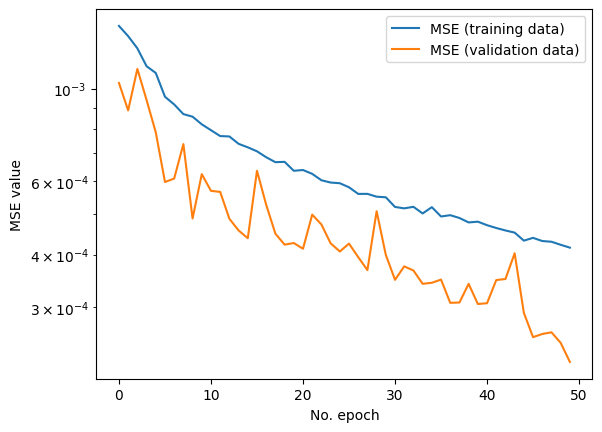

In [ ]:
print(history.history.keys())
plt.figure()
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.savefig('TrainGraph_nu'+f'{n_u}'+'_nl'+f'{n_l}'+'_out'+f'{OUT_STEPS}')  ###
plt.show()



In [ ]:

import tensorflow as tf
from tensorflow import keras

class LSTMModel(tf.keras.Model):
    def __init__(self, hidden_units=128, out_steps=1, **kwargs):
        super().__init__(**kwargs)
        self.out_steps = out_steps
        self.hidden_units = hidden_units
        self.lstm1 = tf.keras.layers.LSTM(hidden_units, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(hidden_units // 2, return_sequences=False)
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs, training=None):
        outputs = []
        for step in range(self.out_steps):
            x = self.lstm1(inputs)
            hidden = self.lstm2(x)
            y = self.dense(hidden)
            inputs = tf.concat([inputs[:, 1:], tf.expand_dims(y, axis=1)], axis=1)
            outputs.append(y)
        return outputs[-1]
class LSTMModel(tf.keras.Model):
    def __init__(self, hidden_units=128, out_steps=1, **kwargs):
        super().__init__(**kwargs)
        self.out_steps = out_steps
        self.hidden_units = hidden_units
        self.lstm1 = tf.keras.layers.LSTM(hidden_units, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(hidden_units // 2, return_sequences=False)
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs, training=None):
        outputs = []
        for step in range(self.out_steps):
            x = self.lstm1(inputs)
            hidden = self.lstm2(x)
            y = self.dense(hidden)
            inputs = tf.concat([inputs[:, 1:], tf.expand_dims(y, axis=1)], axis=1)
            outputs.append(y)
        return outputs[-1]

In [ ]:

results = TestDetection(model)

metrics, residual_absolute, error_absolute_30db, \
PFA_5db, POD_5db, roc_auc_5db, \
PFA_10db, POD_10db, roc_auc_10db, \
PFA_15db, POD_15db, roc_auc_15db, \
PFA_20db, POD_20db, roc_auc_20db, \
PFA_25db, POD_25db, roc_auc_25db, \
PFA_30db, POD_30db, roc_auc_30db = results


40422/40422 ━━━━━━━━━━━━━━━━━━━━ 2004s 50ms/step
40422/40422 ━━━━━━━━━━━━━━━━━━━━ 2000s 49ms/step
40422/40422 ━━━━━━━━━━━━━━━━━━━━ 2000s 49ms/step
40422/40422 ━━━━━━━━━━━━━━━━━━━━ 2000s 49ms/step
40422/40422 ━━━━━━━━━━━━━━━━━━━━ 2001s 49ms/step
40422/40422 ━━━━━━━━━━━━━━━━━━━━ 2003s 50ms/step
40422/40422 ━━━━━━━━━━━━━━━━━━━━ 2004s 50ms/step
📊 Final Evaluation Results


TypeError: unsupported format string passed to list.__format__

Final Evaluation Results
Test MSE: 0.982076
AUC  -5dB: 0.9821
AUC -10dB: 0.9800
AUC -15dB: 0.9647
AUC -20dB: 0.9030
AUC -25dB: 0.5482
AUC -30dB: 0.5204


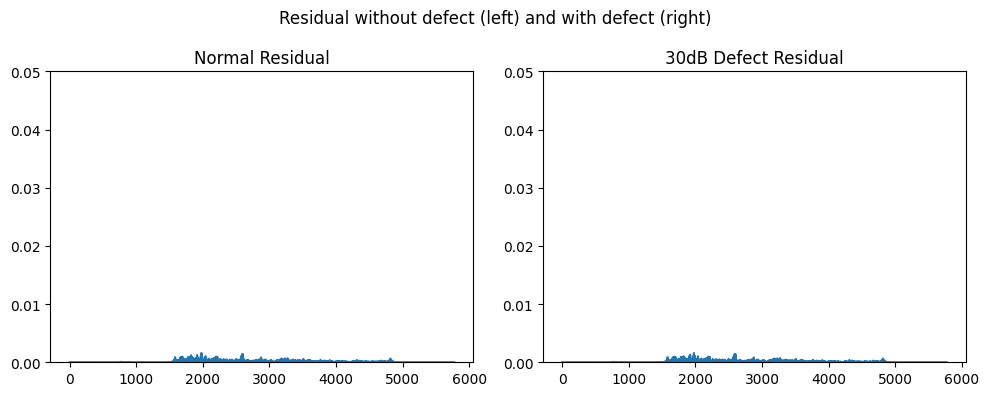

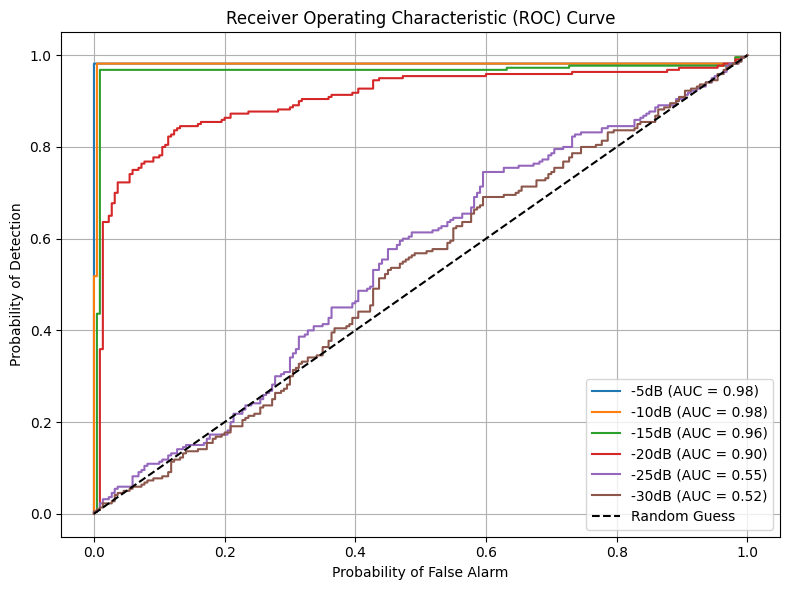

In [ ]:

#  1.  dB AUC
print("Final Evaluation Results")
print(f"Test MSE: {metrics[0]:.6f}")
print(f"AUC  -5dB: {roc_auc_5db:.4f}")
print(f"AUC -10dB: {roc_auc_10db:.4f}")
print(f"AUC -15dB: {roc_auc_15db:.4f}")
print(f"AUC -20dB: {roc_auc_20db:.4f}")
print(f"AUC -25dB: {roc_auc_25db:.4f}")
print(f"AUC -30dB: {roc_auc_30db:.4f}")


#residual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Residual without defect (left) and with defect (right)')
ax1.plot(residual_absolute[:,10])
ax1.set_ylim([0, 0.05])
ax1.set_title("Normal Residual")
ax2.plot(error_absolute_30db[:,10])
ax2.set_ylim([0, 0.05])
ax2.set_title("30dB Defect Residual")
plt.tight_layout()
plt.show()

# 3. ROC 
plt.figure(figsize=(8,6))
plt.plot(PFA_5db, POD_5db, label='-5dB (AUC = %.2f)' % roc_auc_5db)
plt.plot(PFA_10db, POD_10db, label='-10dB (AUC = %.2f)' % roc_auc_10db)
plt.plot(PFA_15db, POD_15db, label='-15dB (AUC = %.2f)' % roc_auc_15db)
plt.plot(PFA_20db, POD_20db, label='-20dB (AUC = %.2f)' % roc_auc_20db)
plt.plot(PFA_25db, POD_25db, label='-25dB (AUC = %.2f)' % roc_auc_25db)
plt.plot(PFA_30db, POD_30db, label='-30dB (AUC = %.2f)' % roc_auc_30db)
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('Probability of False Alarm')
plt.ylabel('Probability of Detection')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


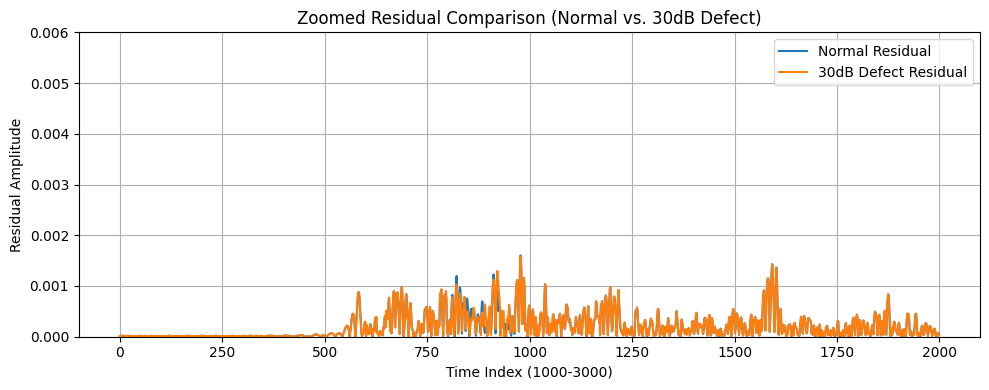

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(residual_absolute[1000:3000, 10], label='Normal Residual', linewidth=1.5)
plt.plot(error_absolute_30db[1000:3000, 10], label='30dB Defect Residual', linewidth=1.5)

plt.ylim([0, 0.006])  
plt.xlabel("Time Index (1000-3000)")
plt.ylabel("Residual Amplitude")
plt.title("Zoomed Residual Comparison (Normal vs. 30dB Defect)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("LSTM_outputs/residual_zoomed_overlay.png", dpi=300)
plt.show()





Testing for the real signal data

In [ ]:
test_size = 4
def TestDetection2(model):
    error_absolute_5db = np.zeros ((test_defect_5db.shape[1], test_size))
    error_absolute_10db = np.zeros ((test_defect_5db.shape[1], test_size))
    error_absolute_15db = np.zeros ((test_defect_5db.shape[1], test_size))
    error_absolute_20db = np.zeros ((test_defect_5db.shape[1], test_size))
    error_absolute_25db = np.zeros ((test_defect_5db.shape[1], test_size))
    error_absolute_30db = np.zeros ((test_defect_5db.shape[1], test_size))
    residual_absolute = np.zeros ((test_defect_5db.shape[1], test_size))

    defect_signals_5db = test_defect_5db.flatten()
    defect_signals_10db = test_defect_10db.flatten()
    defect_signals_15db = test_defect_15db.flatten()
    defect_signals_20db = test_defect_20db.flatten()
    defect_signals_25db = test_defect_25db.flatten()
    defect_signals_30db = test_defect_30db.flatten()
    df_signals = test_signals.flatten()

    test_len =len(defect_signals_5db)- n_h -OUT_STEPS+1


    #替换旧代码
    x_defect_5db, y_defect_5db = generate_lstm_test_data_with_y(defect_signals_5db, n_h, OUT_STEPS)
    x_defect_10db, y_defect_10db = generate_lstm_test_data_with_y(defect_signals_10db, n_h, OUT_STEPS)
    x_defect_15db, y_defect_15db = generate_lstm_test_data_with_y(defect_signals_15db, n_h, OUT_STEPS)
    x_defect_20db, y_defect_20db = generate_lstm_test_data_with_y(defect_signals_20db, n_h, OUT_STEPS)
    x_defect_25db, y_defect_25db = generate_lstm_test_data_with_y(defect_signals_25db, n_h, OUT_STEPS)
    x_defect_30db, y_defect_30db = generate_lstm_test_data_with_y(defect_signals_30db, n_h, OUT_STEPS)
    x_df,y_df = generate_lstm_test_data_with_y(df_signals, n_h, OUT_STEPS)



    predicted_baseline_5db = model.predict(x_defect_5db)
    predicted_baseline_10db = model.predict(x_defect_10db)
    predicted_baseline_15db = model.predict(x_defect_15db)
    predicted_baseline_20db = model.predict(x_defect_20db)
    predicted_baseline_25db = model.predict(x_defect_25db)
    predicted_baseline_30db = model.predict(x_defect_30db)
    baseline_df = model.predict(x_df)

    df_residual = y_df - baseline_df
    df_residual = np.asarray(tf.squeeze(df_residual))
    df_residual = df_residual[-(test_size-1)*test_defect_5db.shape[1]:]
    df_residual = df_residual - statistics.mean(df_residual)

    defect_error_5db = np.asarray(y_defect_5db) - predicted_baseline_5db
    defect_error_5db = np.asarray(tf.squeeze(defect_error_5db))
    defect_error_5db = defect_error_5db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_5db = defect_error_5db - statistics.mean(defect_error_5db)

    defect_error_10db = np.asarray(y_defect_10db) - predicted_baseline_10db
    defect_error_10db = np.asarray(tf.squeeze(defect_error_10db))
    defect_error_10db = defect_error_10db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_10db = defect_error_10db - statistics.mean(defect_error_10db)

    defect_error_15db = np.asarray(y_defect_15db) - predicted_baseline_15db
    defect_error_15db = np.asarray(tf.squeeze(defect_error_15db))
    defect_error_15db = defect_error_15db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_15db = defect_error_15db - statistics.mean(defect_error_15db)

    defect_error_20db = np.asarray(y_defect_20db) - predicted_baseline_20db
    defect_error_20db = np.asarray(tf.squeeze(defect_error_20db))
    defect_error_20db = defect_error_20db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_20db = defect_error_20db - statistics.mean(defect_error_20db)

    defect_error_25db = np.asarray(y_defect_25db) - predicted_baseline_25db
    defect_error_25db = np.asarray(tf.squeeze(defect_error_25db))
    defect_error_25db = defect_error_25db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_25db = defect_error_25db - statistics.mean(defect_error_25db)

    defect_error_30db = np.asarray(y_defect_30db) - predicted_baseline_30db
    defect_error_30db = np.asarray(tf.squeeze(defect_error_30db))
    defect_error_30db = defect_error_30db[-(test_size-1)*test_defect_5db.shape[1]:]
    defect_error_30db = defect_error_30db - statistics.mean(defect_error_30db)

    for k in range(test_size-1):
        error_absolute_5db [:,k] = defect_error_5db[k*test_defect_5db.shape[1]: (k+1)*test_defect_5db.shape[1]] *scale_defect_5db
        error_absolute_5db [:,k] = np.multiply(error_absolute_5db [:,k], scale[k])
        error_absolute_5db [:,k] = abs(error_absolute_5db [:,k])

        error_absolute_10db [:,k] = defect_error_10db[k*test_defect_10db.shape[1]: (k+1)*test_defect_10db.shape[1]] *scale_defect_10db
        error_absolute_10db [:,k] = np.multiply(error_absolute_10db [:,k], scale[k])
        error_absolute_10db [:,k] = abs(error_absolute_10db [:,k])

        error_absolute_15db [:,k] = defect_error_15db[k*test_defect_15db.shape[1]: (k+1)*test_defect_15db.shape[1]] *scale_defect_15db
        error_absolute_15db [:,k] = np.multiply(error_absolute_15db [:,k], scale[k])
        error_absolute_15db [:,k] = abs(error_absolute_15db [:,k])

        error_absolute_20db [:,k] = defect_error_20db[k*test_defect_20db.shape[1]: (k+1)*test_defect_20db.shape[1]] *scale_defect_20db
        error_absolute_20db [:,k] = np.multiply(error_absolute_20db [:,k], scale[k])
        error_absolute_20db [:,k] = abs(error_absolute_20db [:,k])

        error_absolute_25db [:,k] = defect_error_25db[k*test_defect_25db.shape[1]: (k+1)*test_defect_25db.shape[1]] *scale_defect_25db
        error_absolute_25db [:,k] = np.multiply(error_absolute_25db [:,k], scale[k])
        error_absolute_25db [:,k] = abs(error_absolute_25db [:,k])

        error_absolute_30db [:,k] = defect_error_30db[k*test_defect_30db.shape[1]: (k+1)*test_defect_30db.shape[1]] *scale_defect_30db
        error_absolute_30db [:,k] = np.multiply(error_absolute_30db [:,k], scale[k])
        error_absolute_30db [:,k] = abs(error_absolute_30db [:,k])

        residual_absolute [:,k] = df_residual[k*test_defect_5db.shape[1]: (k+1)*test_defect_5db.shape[1]]
        residual_absolute [:,k] = np.multiply(residual_absolute [:,k], scale[k])
        residual_absolute [:,k] = abs(residual_absolute [:,k])

    error_absolute_5db = error_absolute_5db [-error_len:-5,:]
    error_absolute_10db = error_absolute_10db [-error_len:-5,:]
    error_absolute_15db = error_absolute_15db [-error_len:-5,:]
    error_absolute_20db = error_absolute_20db [-error_len:-5,:]
    error_absolute_25db = error_absolute_25db [-error_len:-5,:]
    error_absolute_30db = error_absolute_30db [-error_len:-5,:]
    residual_absolute = residual_absolute [-error_len:-5,:]

    max_residual = np.amax(residual_absolute, axis = 0)
    max_error_5db = np.amax(error_absolute_5db, axis = 0)
    max_error_10db = np.amax(error_absolute_10db, axis = 0)
    max_error_15db = np.amax(error_absolute_15db, axis = 0)
    max_error_20db = np.amax(error_absolute_20db, axis = 0)
    max_error_25db = np.amax(error_absolute_25db, axis = 0)
    max_error_30db = np.amax(error_absolute_30db, axis = 0)

    scores_5db = np.concatenate((max_residual,max_error_5db))
    scores_10db = np.concatenate((max_residual,max_error_10db))
    scores_15db = np.concatenate((max_residual, max_error_15db))
    scores_20db = np.concatenate((max_residual,max_error_20db))
    scores_25db = np.concatenate((max_residual,max_error_25db))
    scores_30db = np.concatenate((max_residual,max_error_30db))
    label1 = np.zeros((len(max_residual)))
    label2 = np.ones((len(max_error_5db)))
    label = np.concatenate((label1, label2))
    PFA_5db, POD_5db, thresholds_5db = roc_curve(label, scores_5db)
    PFA_10db, POD_10db, thresholds_10db = roc_curve(label, scores_10db)
    PFA_15db, POD_15db, thresholds_15db = roc_curve(label, scores_15db)
    PFA_20db, POD_20db, thresholds_20db = roc_curve(label, scores_20db)
    PFA_25db, POD_25db, thresholds_25db = roc_curve(label, scores_25db)
    PFA_30db, POD_30db, thresholds_30db = roc_curve(label, scores_30db)

    roc_auc_5db = auc(PFA_5db, POD_5db)
    roc_auc_10db = auc(PFA_10db, POD_10db)
    roc_auc_15db = auc(PFA_15db, POD_15db)
    roc_auc_20db = auc(PFA_20db, POD_20db)
    roc_auc_25db = auc(PFA_25db, POD_25db)
    roc_auc_30db = auc(PFA_30db, POD_30db)

    square_error= np.square(residual_absolute).flatten()
    test_mse = np.mean(square_error, axis=0)
    #return [roc_auc_5db,roc_auc_10db, roc_auc_15db,roc_auc_20db,roc_auc_25db,roc_auc_30db, test_mse]
    return (
    [roc_auc_5db, roc_auc_10db, roc_auc_15db, roc_auc_20db, roc_auc_25db, roc_auc_30db, test_mse],
    residual_absolute, 
    error_absolute_30db,
    error_absolute_5db,
    error_absolute_10db,
    error_absolute_15db,
    error_absolute_20db,
    error_absolute_25db,
    PFA_5db, POD_5db, roc_auc_5db,
    PFA_10db, POD_10db, roc_auc_10db,
    PFA_15db, POD_15db, roc_auc_15db,
    PFA_20db, POD_20db, roc_auc_20db,
    PFA_25db, POD_25db, roc_auc_25db,
    PFA_30db, POD_30db, roc_auc_30db
)


In [47]:



#Load Test Data
f2 = scipy.io.loadmat('test_signals.mat')
test_signals = np.array(f2['test_signals'])
f3 = scipy.io.loadmat('test_defect1.mat')
test_defect_5db = np.array(f3['test_defect1'])

f4 = scipy.io.loadmat('test_defect2.mat')
test_defect_10db = np.array(f4['test_defect2'])

f5 = scipy.io.loadmat('test_defect3.mat')
test_defect_20db = np.array(f5['test_defect3'])

f6 = scipy.io.loadmat('test_defect4.mat')
test_defect_25db = np.array(f6['test_defect4'])
f7 = scipy.io.loadmat('test_defect6.mat')
test_defect_30db = np.array(f7['test_defect6'])
f9 = scipy.io.loadmat('test_defect5.mat')
test_defect_15db = np.array(f9['test_defect5'])

scale_defect_15db = np.amax(abs(test_defect_15db))
test_defect_15db = test_defect_15db / scale_defect_15db


f8 = scipy.io.loadmat('scale.mat')
scale = np.array(f8['max_values'])
#scale = scale[0,0:test_size] # (1,220)
# (220,)
if scale.ndim == 2 and scale.shape[1] == 1:
    scale = scale[:, 0]
print("scale.shape:", scale.shape)

scale = scale[:test_size]

scale_defect_5db = np.amax(abs(test_defect_5db))
scale_defect_10db = np.amax(abs(test_defect_10db))
scale_defect_20db = np.amax(abs(test_defect_20db))
scale_defect_25db = np.amax(abs(test_defect_25db))
scale_defect_30db = np.amax(abs(test_defect_30db))

test_defect_5db = test_defect_5db/scale_defect_5db
test_defect_10db = test_defect_10db/scale_defect_10db
test_defect_20db = test_defect_20db/scale_defect_20db
test_defect_25db = test_defect_25db/scale_defect_25db
test_defect_30db = test_defect_30db/scale_defect_30db


scale.shape: (4,)


In [ ]:
results = TestDetection2(model)


metrics, \
residual_absolute, \
error_absolute_5db, \
error_absolute_10db, \
error_absolute_15db, \
error_absolute_20db, \
error_absolute_25db, \
error_absolute_30db, \
PFA_5db, POD_5db, roc_auc_5db, \
PFA_10db, POD_10db, roc_auc_10db, \
PFA_15db, POD_15db, roc_auc_15db, \
PFA_20db, POD_20db, roc_auc_20db, \
PFA_25db, POD_25db, roc_auc_25db, \
PFA_30db, POD_30db, roc_auc_30db = results

#  1.AUC
print("Final Evaluation Results")
print(f"Test MSE: {metrics[0]:.6f}")
print(f"AUC  d1: {roc_auc_5db:.8f}")
print(f"AUC d2: {roc_auc_10db:.8f}")
print(f"AUC d3: {roc_auc_15db:.8f}")
print(f"AUC d4: {roc_auc_20db:.8f}")
print(f"AUC d5: {roc_auc_25db:.8f}")
print(f"AUC d6: {roc_auc_30db:.8f}")




607/607 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step
Final Evaluation Results
Test MSE: 0.781250
AUC  d1: 0.78125000
AUC d2: 0.78125000
AUC d3: 0.78125000
AUC d4: 0.78125000
AUC d5: 0.78125000
AUC d6: 0.78125000


<Figure size 1000x500 with 0 Axes>

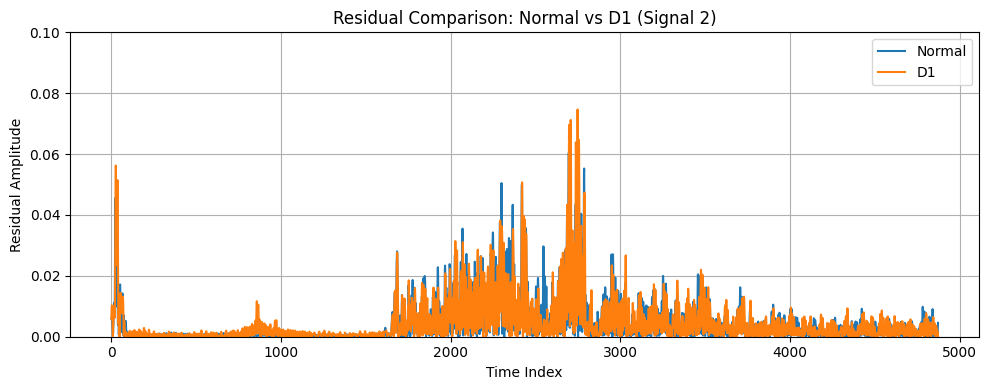

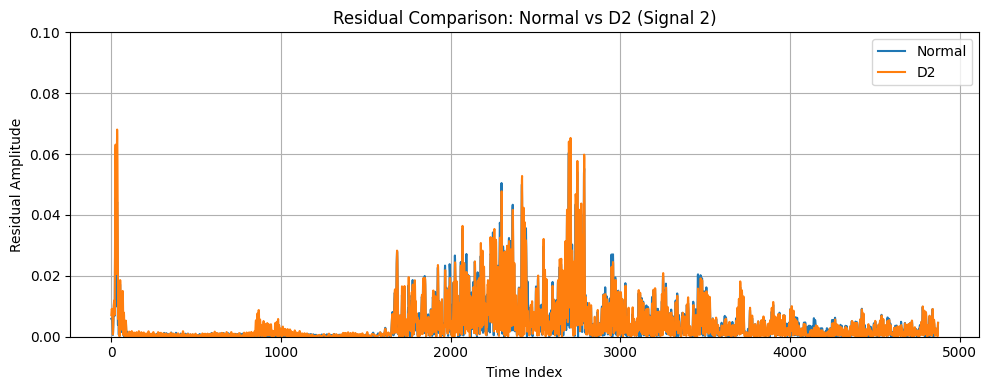

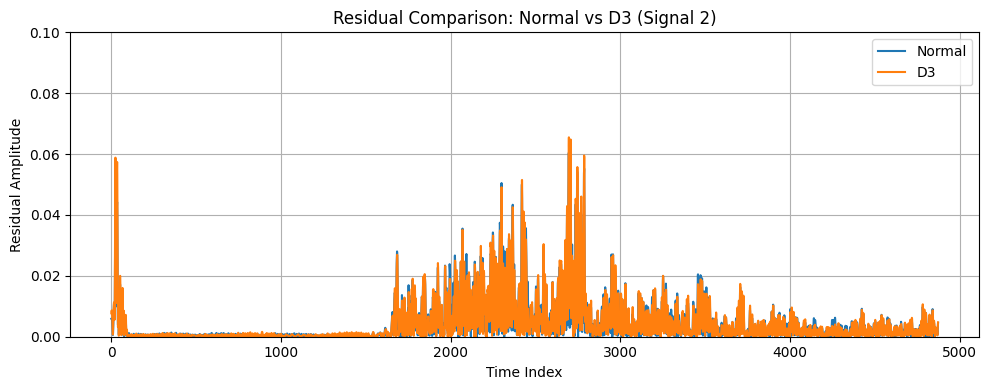

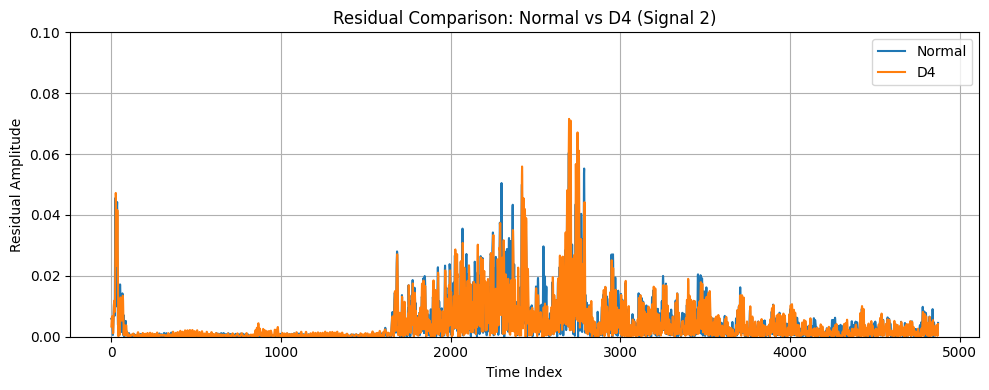

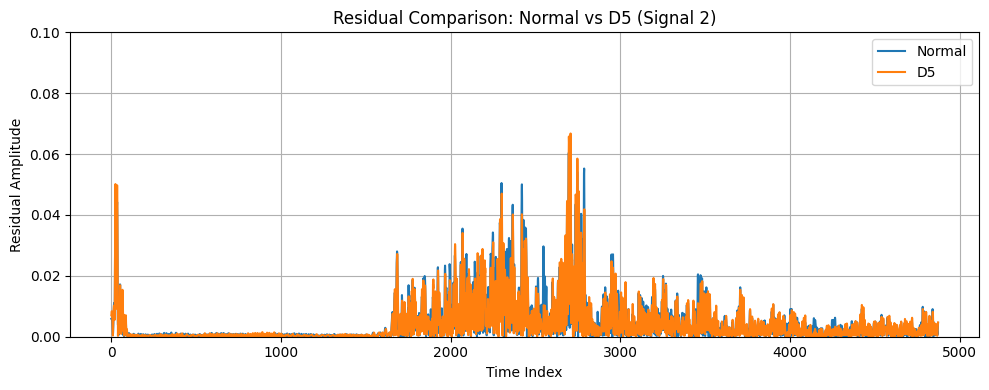

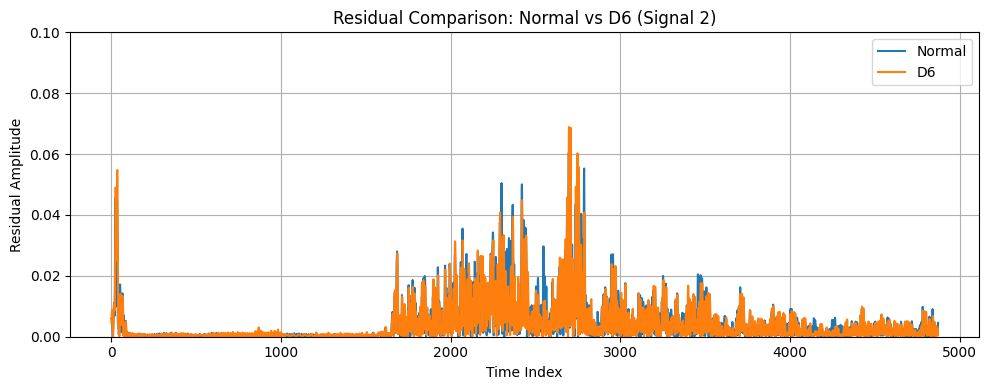

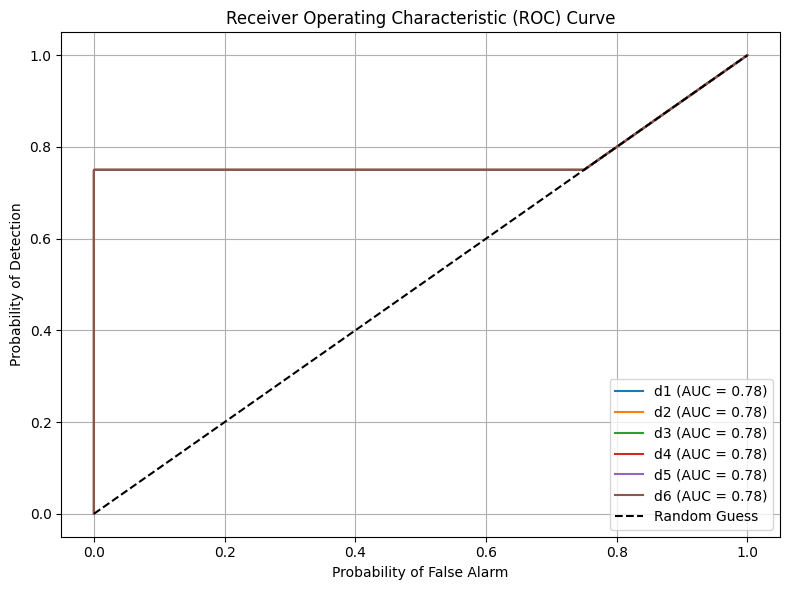

In [ ]:
#residual comparison
plt.figure(figsize=(10, 5))
signal_index = 1  

defects = [
    error_absolute_5db,
    error_absolute_10db,
    error_absolute_15db,
    error_absolute_20db,
    error_absolute_25db,
    error_absolute_30db
]
labels = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6']

for i, (defect, label) in enumerate(zip(defects, labels), start=1):
    plt.figure(figsize=(10, 4))
    plt.plot(residual_absolute[:, signal_index], label='Normal', linewidth=1.5)
    plt.plot(defect[:, signal_index], label=f'{label}', linewidth=1.5)
    plt.ylim([0, 0.1])
    plt.xlabel("Time Index")
    plt.ylabel("Residual Amplitude")
    plt.title(f"Residual Comparison: Normal vs {label} (Signal {signal_index + 1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 3. ROC 
plt.figure(figsize=(8,6))
plt.plot(PFA_5db, POD_5db, label='d1 (AUC = %.2f)' % roc_auc_5db)
plt.plot(PFA_10db, POD_10db, label='d2 (AUC = %.2f)' % roc_auc_10db)
plt.plot(PFA_15db, POD_15db, label='d3 (AUC = %.2f)' % roc_auc_15db)
plt.plot(PFA_20db, POD_20db, label='d4 (AUC = %.2f)' % roc_auc_20db)
plt.plot(PFA_25db, POD_25db, label='d5 (AUC = %.2f)' % roc_auc_25db)
plt.plot(PFA_30db, POD_30db, label='d6 (AUC = %.2f)' % roc_auc_30db)
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('Probability of False Alarm')
plt.ylabel('Probability of Detection')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
print("Final Evaluation Results")
print(f"Test MSE: {metrics[0]:.6f}")
print(f"AUC  d1: {roc_auc_5db:.8f}")
print(f"AUC d2: {roc_auc_10db:.8f}")
print(f"AUC d3: {roc_auc_15db:.8f}")
print(f"AUC d4: {roc_auc_20db:.8f}")
print(f"AUC d5: {roc_auc_25db:.8f}")
print(f"AUC d6: {roc_auc_30db:.8f}")


Final Evaluation Results
Test MSE: 0.781250
AUC  d1: 0.78125000
AUC d2: 0.78125000
AUC d3: 0.78125000
AUC d4: 0.78125000
AUC d5: 0.78125000
AUC d6: 0.78125000


In [59]:
evaluate_mse_mae(residual_absolute,
                 error_absolute_5db,
                 error_absolute_10db,
                 error_absolute_15db,
                 error_absolute_20db,
                 error_absolute_25db,
                 error_absolute_30db)

 MSE / MAE result：
Normal → MSE: 0.000062, MAE: 0.003777
Defect d1 → MSE: 0.000065, MAE: 0.003884
Defect d2 → MSE: 0.000068, MAE: 0.003940
Defect d3 → MSE: 0.000066, MAE: 0.003843
Defect d4 → MSE: 0.000064, MAE: 0.003775
Defect d5 → MSE: 0.000059, MAE: 0.003668
Defect d6 → MSE: 0.000060, MAE: 0.003710
